# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

TODO:
1. DONE - fix pi0 to be bad enough
1. DONE - make sure propensities are not all 0
1. DONE - add check for propensity overfitting
1. SEEMS OK - fix optim to work correctly -- but POEM cannot work with LBFG-S (see paper)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [5]:
import matplotlib.pyplot as plt

In [6]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [7]:
#dataset_name='scene'
dataset_name='yeast'
# dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)

X_train: (1812, 104) y_train: (1812, 14)


### Baselines & Skylines

In [8]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train, mlp=True)

In [9]:
sampling_probas = pi0.predict_proba(X_train)
sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T 

In [10]:
sampling_probas.min(axis=0)

array([0.04196816, 0.07985135, 0.07448589, 0.01369675, 0.00762209,
       0.01825114, 0.0269684 , 0.02914602, 0.00790334, 0.00671692,
       0.00631266, 0.13104026, 0.13177221, 0.00547145])

In [11]:
log_props_per_instance = jnp.log(sampling_probas).sum(axis=1)
n_zero_props = (jnp.exp(log_props_per_instance) == 0).astype(int).sum()
print(n_zero_props, '/', sampling_probas.shape[0], 'train instances have 0 propensity')
assert (n_zero_props / sampling_probas.shape[0]) < .1

0 / 1812 train instances have 0 propensity


# The Experiment

In [77]:
def evaluate_model(model: Model, losses, rewards, i, j):
    losses[i,j] = model.expected_hamming_loss(X_test, y_test)
    test_dataset = CRMDataset().update_from_supervised_dataset(X_test, y_test, 
                                                               model.predict_proba(X_test, np.ones_like(y_test)), n_samples=4)
    rewards[i,j] = test_dataset.rewards.sum() / (len(test_dataset)*test_dataset.actions.shape[1])

In [78]:
replay_targets = 2**np.arange(8)
replay_targets

array([  1,   2,   4,   8,  16,  32,  64, 128])

In [79]:
n_splits = 10

In [80]:
crm_losses = np.ones((10, len(replay_targets,)))
crm_rewards = np.ones((10, len(replay_targets,)))

for i in range(n_splits):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        evaluate_model(crm_model, crm_losses, crm_rewards, i, j)
        # CRM is playing with pi0
        test_sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T
        test_dataset = CRMDataset().update_from_supervised_dataset(X_test, y_test, test_sampling_probas, n_samples=4)
        crm_rewards[i,j] = test_dataset.rewards.sum() / (len(test_dataset)*test_dataset.actions.shape[1])
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        crm_dataset.update_from_supervised_dataset(X_train, y_train, sampling_probas, n_samples=needed_replays)
        crm_model.fit(
            crm_dataset, 
            lambda_ = .5,
            verbose = 0
        )            

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)

0. . . . . . . . 1. . . . . . . . 2. . . . . . . . 3. . . . . . . . 4. . . . . . . . 5. . . . . . . . 6. . . . . . . . 7. . . . . . . . 8. . . . . . . . 9. . . . . . . . 

In [40]:
# ucrm_losses = np.ones((10, len(replay_targets,)))
# ucrm_rewards = np.ones((10, len(replay_targets,)))

# for i in range(n_splits):
#     print(i, end='')
#     np.random.seed(i*42)
#     current_replay = 0
#     ucrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
#     ucrm_dataset = CRMDataset()
#     for j, replay_target in enumerate(replay_targets):
#         print('.', end=' ')
#         evaluate_model(ucrm_model, ucrm_losses, ucrm_rewards, i, j)
#         needed_replays = replay_target - current_replay
#         current_replay = replay_target
#         ucrm_dataset.update_from_supervised_dataset(X_train, y_train, .5*np.ones_like(sampling_probas), n_samples=needed_replays)
#         ucrm_model.fit(
#             ucrm_dataset, 
#             lambda_ = .5,
#             verbose = 0
#         )
        
# ucrm_losses = ucrm_losses.mean(axis=0)
# ucrm_rewards = ucrm_rewards.mean(axis=0)

In [81]:
scrm_losses = np.ones((10, len(replay_targets,)))
scrm_rewards = np.ones((10, len(replay_targets,)))

for i in range(n_splits):
    print(i, end='')
    np.random.seed(i*42)
    current_replay = 0
    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    for j, replay_target in enumerate(replay_targets):
        print('.', end=' ')
        evaluate_model(scrm_model, scrm_losses, scrm_rewards, i, j)
        needed_replays = replay_target - current_replay
        current_replay = replay_target
        scrm_sampling_probas = scrm_model.predict_proba(X_train, y_train)
        scrm_dataset.update_from_supervised_dataset(X_train, y_train, scrm_sampling_probas, n_samples=needed_replays)
        scrm_model.fit(
            scrm_dataset, 
            lambda_ = scrm_model.theoretical_exploration_bonus(len(scrm_dataset), replay_target * len(X_train)),
            verbose = 0
        )

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)

0. . . . . . . . 1. . . . . . . . 2. . . . . . . . 3. . . . . . . . 4. . . . . . . . 5. . . . . . . . 6. . . . . . . . 7. . . . . . . . 8. . . . . . . . 9. . . . . . . . 

In [42]:
# mscrm_losses = np.ones((10, len(replay_targets,)))
# mscrm_rewards = np.ones((10, len(replay_targets,)))

# for i in range(n_splits):
#     print(i, end='')
#     np.random.seed(i*42)
#     current_replay = 0
#     mscrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
#     for j, replay_target in enumerate(replay_targets):
#         print('.', end=' ')
#         evaluate_model(mscrm_model, mscrm_losses, mscrm_rewards, i, j)
#         needed_replays = replay_target - current_replay
#         current_replay = replay_target
#         mscrm_sampling_probas = mscrm_model.predict_proba(X_train, y_train)
#         mscrm_dataset = CRMDataset()
#         mscrm_dataset.update_from_supervised_dataset(X_train, y_train, mscrm_sampling_probas, n_samples=needed_replays)
#         mscrm_model.fit(
#             mscrm_dataset, 
#             lambda_ = .5,
#             verbose = 0
#         )

# mscrm_losses = mscrm_losses.mean(axis=0)
# mscrm_rewards = mscrm_rewards.mean(axis=0)

In [43]:
baseline_reward = CRMDataset().update_from_supervised_dataset(
    X_test, y_test, 
    np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T, n_samples=4
).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
baseline_rewards = baseline_reward * np.ones_like(crm_rewards)

skyline_reward = CRMDataset().update_from_supervised_dataset(
    X_test, y_test, 
    np.array([_[:,1] for _ in pistar.predict_proba(X_test)]).T, n_samples=4
).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
skyline_rewards = skyline_reward * np.ones_like(crm_rewards)

In [82]:
crm_rewards, baseline_rewards

(array([0.52766529, 0.52824675, 0.52701889, 0.52634888, 0.52798701,
        0.52664404, 0.52716057, 0.52729044]),
 array([0.5272137, 0.5272137, 0.5272137, 0.5272137, 0.5272137, 0.5272137,
        0.5272137, 0.5272137]))

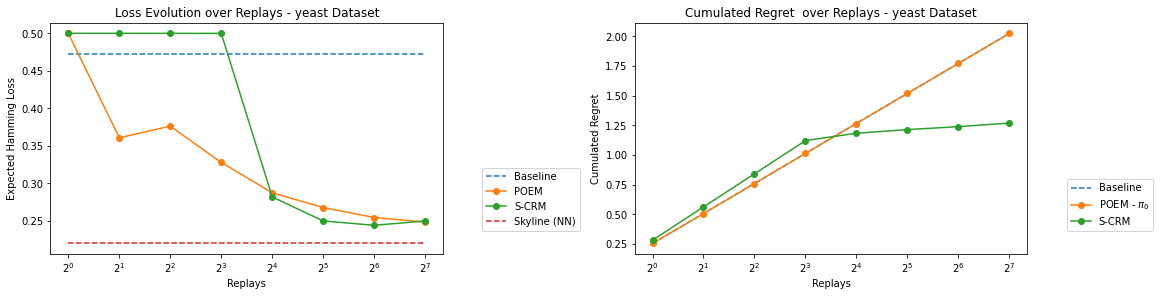

In [89]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(16,4))
ax1.set_title('Loss Evolution over Replays - %s Dataset' % dataset_name)
ax1.set_xlabel('Replays')
ax1.set_xscale('log', base=2)
ax1.plot(replay_targets, .473*np.ones_like(replay_targets), '--', label='Baseline')
# ax.plot(replay_targets, ucrm_losses, 'o-', label='POEM Unif.')
ax1.plot(replay_targets, crm_losses, 'o-', label='POEM')
ax1.plot(replay_targets, scrm_losses, 'o-', label='S-CRM')
# ax.plot(replay_targets, mscrm_losses, 'o-', label='MS-CRM')
#ax.plot(replay_targets, .295*np.ones_like(replay_targets), '--', label='Skyline (LR)')
ax1.plot(replay_targets, .220*np.ones_like(replay_targets), '--', label='Skyline (NN)')
ax1.set_ylabel('Expected Hamming Loss')
ax1.legend(loc=(1.1, .1))

ax2.set_title('Cumulated Regret  over Replays - %s Dataset' % dataset_name)
ax2.set_xlabel('Replays')
ax2.set_xscale('log', base=2)
ax2.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(baseline_rewards), '--', label='Baseline')
ax2.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(crm_rewards), 'o-', label='POEM - $\pi_0$')
ax2.plot(replay_targets, np.cumsum(skyline_rewards) - np.cumsum(scrm_rewards), 'o-', label='S-CRM')
ax2.set_ylabel('Cumulated Regret')
ax2.legend(loc=(1.1, .1))